In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pyccl as ccl
import os.path
import math
from os.path import exists as file_exists
import sacc
from scipy.stats import chi2 as chi2f
from scipy.interpolate import interp1d

### 1. Read data and preliminary setup

In [2]:
s = sacc.Sacc.load_fits("../../fermi_x_galaxies.fits")
s.remove_selection(ell__gt=2048)
s.remove_selection(ell__lt=30)

num_gal = 6
num_gam = 12

# Calculate number of ells
ells, _ = s.get_ell_cl('cl_00', 'gal0', 'gam0')
num_ell = len(ells)

# Calculate number of redshifts
zs = s.tracers['gal5'].z
num_z = len(zs)

# Resample first redshift bin at the same redshifts as the rest
nz0_i = interp1d(s.tracers['gal0'].z, s.tracers['gal0'].nz, bounds_error=False, fill_value=0)
s.tracers['gal0'].z = zs
s.tracers['gal0'].nz = nz0_i(zs)

# Extract beams
goodl = [ell in ells for ell in s.tracers['gam0'].ell]
beams = {f'gam{igam}': s.tracers[f'gam{igam}'].beam[goodl]
         for igam in range(num_gam)}

### 2. Plot things a bit

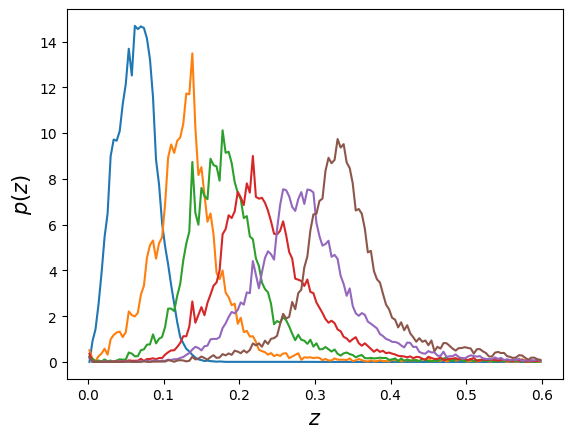

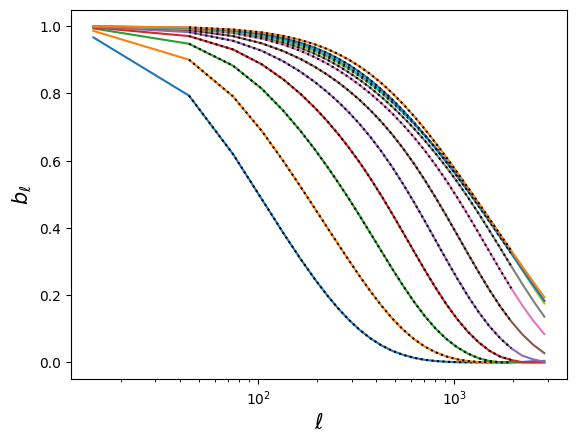

In [3]:
# N(z)
plt.figure()
for igal in range(num_gal):
    t = s.tracers[f'gal{igal}']
    plt.plot(t.z, t.nz)
plt.xlabel(r'$z$', fontsize=15)
plt.ylabel(r'$p(z)$', fontsize=15)

# Beams
plt.figure()
for igam in range(num_gam):
    t = s.tracers[f'gam{igam}']
    plt.plot(t.ell, t.beam)
    plt.plot(ells, beams[f'gam{igam}'], 'k:')
plt.xscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$b_\ell$', fontsize=15);

### 2. Create window functions

$$
W_{n,i}(z) = \int_{\varepsilon_i(1+z)}^{\varepsilon_{i+1}(1+z)}d\epsilon\,\Theta(\epsilon_n<\epsilon<\epsilon_{n+1})
$$
which is
$$
W_{n,i}(z) = \left[{\rm min}(\varepsilon_{i+1}(1+z),\epsilon_{n+1})-{\rm max}(\varepsilon_i(1+z),\varepsilon_n)\right]\Theta(\epsilon_{n+1}>\varepsilon_i(1+z))\Theta(\epsilon_n<\varepsilon_{i+1}(1+z))
$$

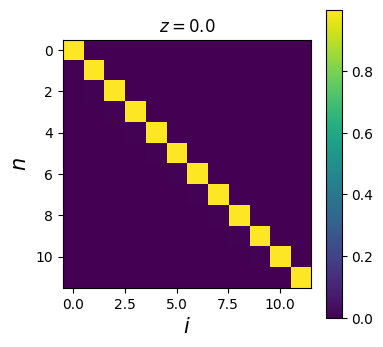

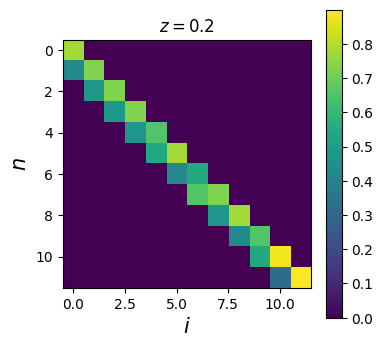

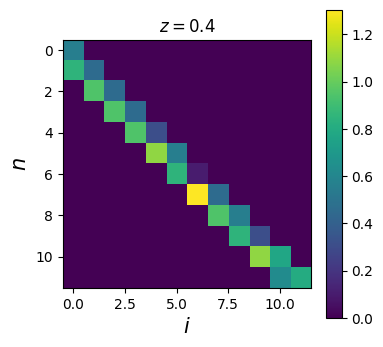

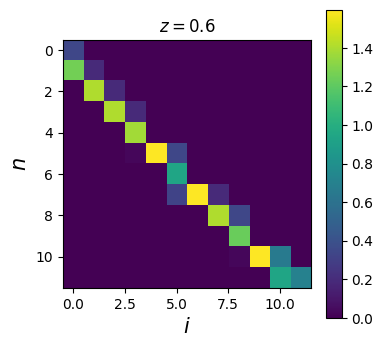

In [4]:
# Energy ranges in GeV
E_obs = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
                  5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
                  3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
                  1.00000000e+06])*1E-3
# Rest-frame
E_emt = E_obs[:, None]*(1+zs[None, :])
num_E = len(E_obs)-1
assert num_E == num_gam
windows = np.zeros([num_E, num_gam, num_z])

for n in range(num_E):
    for i in range(num_gam):
        E_n = E_obs[n]
        E_i = E_obs[i]
        E_i_oneplusz = E_emt[i]
        E_np = E_obs[n+1]
        E_ip = E_obs[i+1]
        E_ip_oneplusz = E_emt[i+1]
        Emin = np.minimum(E_ip_oneplusz, E_np)
        Emax = np.maximum(E_i_oneplusz, E_n)
        good_n = E_ip_oneplusz > E_n
        good_np = E_i_oneplusz < E_np
        win = (Emin-Emax)*good_n*good_np
        windows[n, i, :] = win

Ediff = E_obs[1:]-E_obs[:-1]
for iz in [0, 50, 100, -1]:
    plt.figure(figsize=(4, 4))
    plt.title(r"$z=%.1lf$" % zs[iz])
    plt.imshow(windows[:, :, iz]/Ediff[None, :])
    plt.colorbar()
    plt.xlabel(r'$i$', fontsize=15)
    plt.ylabel(r'$n$', fontsize=15)


### 3. Calculate template power spectra

In [5]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96) #need to make a K(z) function
k_arr = np.geomspace(1e-4,100,256)
a = 1./(1+zs)
a_arr = a[::-1]
chi = ccl.comoving_radial_distance(cosmo,a_arr)[::-1]

# We will use a mass definition with Delta = 200 times the critical density
hmd_200c = ccl.halos.MassDef200c() 
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)
# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)
# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200c)
# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)
# Halo model calculator
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200c)
pk_MDM = ccl.halos.halomod_Pk2D(cosmo, hmc, pM, prof2=pM,
                                 normprof1=True, normprof2=True,
                                 lk_arr=np.log(k_arr), a_arr=a_arr)

bias = np.array([1.182,1.086,1.126,1.144,1.206,1.548])

# This is density in M_sun/Mpc^3
rho_x = ccl.background.rho_x(cosmo, 1, 'matter',
                             is_comoving = True)
C = rho_x/(4*np.pi*(1+zs))

tgal = []
for gal in range(0,6):
    tr = s.tracers[f'gal{gal}']
    t = ccl.NumberCountsTracer(cosmo, has_rsd = False,
                               dndz=(tr.z, tr.nz),
                               bias=(tr.z, np.full_like(tr.z, bias[gal])))
    tgal.append(t)

# C_ell will have units of M_sun*GeV/Mpc^2
cl_th = np.zeros([num_gal, num_E, num_gam, num_ell])
for ig, g in enumerate(tgal):
    for n in range(num_E):
        for i in range(num_gam):
            GRB_tracer = ccl.Tracer()
            GRB_tracer.add_tracer(cosmo, kernel=(chi, C*windows[n, i]))
            cl_theoretical = ccl.angular_cl(cosmo, g, GRB_tracer, ells, p_of_k_a= pk_MDM)
            cl_th[ig, n, i, :] = cl_theoretical*beams[f'gam{i}']

### 4. Measure F!
For this, we do:
$$
{\bf F}={\sf C}_F\,{\bf A}
$$
With
$$
({\sf C}_F^{-1})_{mn}=\sum_{gi\ell}\sum_{g'i'\ell'}C_\ell^{g,in}({\rm Cov}^{-1})_{(gi\ell),(g'i'\ell')}C_{\ell'}^{g',i'm}
$$
and
$$
A_n=\sum_{gi\ell}\sum_{g'i'\ell'}C_\ell^{g,in}({\rm Cov}^{-1})_{(gi\ell),(g'i'\ell')}\hat{C}_{\ell'}^{g'i'}
$$
Note that ${\sf C}_F$ also happens to be the covariance of ${\bf F}$.

Here $\hat{C}_\ell^{gi}$ is the data $g-i$ cross-correlation, and $C^{g,in}_\ell$ is the theoretical template for galaxy sample $g$ and window function $W_{n,i}(z)$.

At the end we multiply the result by $8.53323018\times10^{-9}$ to convert $F$ from ${\rm cm}^{-1}{\rm s}^{-1}{\rm Mpc}^2 M_\odot^{-1}\,{\rm GeV}$ to ${\rm s}^{-1}\,{\rm GeV}^{-2}$.

In [6]:
def get_F(gals):
    print(gals)
    prefac = 8.53323018E-9
    ngal = len(gals)
    gams = range(num_gam)

    # Get indices
    indices = []
    cl_data = []
    for igal, gal in enumerate(gals):
        indices.append([])
        cl_data.append([])
        for gam in gams:
            _, cl, ind = s.get_ell_cl('cl_00', f'gal{gal}', f'gam{gam}', return_ind=True)
            indices[igal].append(ind)
            cl_data[igal].append(cl)
    indices = np.array(indices)
    cl_data = np.array(cl_data)

    # Get theory C_ells
    # Shape: [ngal, n_n, n_i, ell]
    cl_theory = np.array([cl_th[ig] for ig in gals])
    # Shape: [n_n, ngal, n_i, ell]
    cl_theory = np.transpose(cl_theory, axes=[1, 0, 2, 3])

    # Flatten all relevant dimensions
    cl_data = cl_data.flatten()
    indices = indices.flatten()
    cl_theory = cl_theory.reshape([num_E, -1])

    # Construct covariance
    cv = s.covariance.covmat.copy()
    cv = cv[indices][:, indices]

    # Q matrix
    # Cov^-1 C_th
    iC_th = np.array([np.linalg.solve(cv, th)
                      for th in cl_theory])
    # C_th^T Cov^-1 C_th
    Q = np.sum(cl_theory[:, None, :]*iC_th[None, :, :], axis=-1)

    # A vector
    # C_th^T Cov^-1 d
    A = np.dot(cl_theory, np.linalg.solve(cv, cl_data))

    # F = Q^-1 F
    cov_F = np.linalg.inv(Q)
    F = np.dot(cov_F, A)

    # Chi^2 improvement
    chi20 = np.dot(cl_data, np.linalg.solve(cv, cl_data))
    res = cl_data - np.dot(F, cl_theory)
    chi2 = np.dot(res, np.linalg.solve(cv, res))
    print(chi20-chi2, len(F), np.sqrt(chi20-chi2-len(F)))

    # Prefactors
    F *= prefac
    cov_F *= prefac**2

    return F, cov_F

In [7]:
res_F = {f'gal{i}': get_F([i]) for i in range(6)}
res_F['total'] = get_F(range(6))

[0]
28.588875569698246 12 4.0729443366805596
[1]
37.32800688406152 12 5.032693799950631
[2]
43.68051917949674 12 5.628545032199417
[3]
52.47252537354109 12 6.361802053942035
[4]
37.381609273750655 12 5.038016402687734
[5]
25.926548565473325 12 3.731829117935778
range(0, 6)
82.11840294706622 12 8.373673205175027


Let's plot the result!

gal0 4.072944336680576
gal1 5.032693799950646
gal2 5.62854503219941
gal3 6.361802053942065
gal4 5.03801640268771
gal5 3.731829117935781
total 8.373673205175374


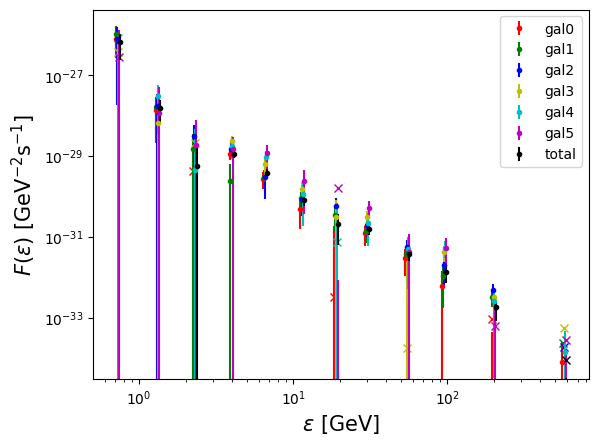

In [8]:
cols = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
E_mid = np.sqrt(E_obs[1:]*E_obs[:-1])
for i, (k, (F, cov_F)) in enumerate(res_F.items()):
    col = cols[i]
    plt.errorbar(E_mid*(1+0.01*i-0.03), F, yerr=np.sqrt(np.diag(cov_F)), fmt=col+'.', label=k)
    plt.plot(E_mid*(1+0.01*i-0.03), -F, col+'x')
    print(k, np.sqrt(np.dot(F, np.linalg.solve(cov_F, F)) - len(F)))
plt.loglog()
plt.legend()
plt.xlabel(r'$\epsilon\,\,[{\rm GeV}]$', fontsize=15)
plt.ylabel(r'$F(\epsilon)\,\,[{\rm GeV}^{-2}{\rm s}^{-1}]$', fontsize=15);

In [9]:
Fsave = np.array([v[0] for k, v in res_F.items()])
covFsave = np.array([v[1] for k, v in res_F.items()])
names = [k for k, v in res_F.items()]
np.savez("F_decay.npz", names=names, F=Fsave, covF=covFsave)

### 5. Calculate F amplitude
Fit $F(\epsilon)$ to a model of the form $F_0(\epsilon/\epsilon_0)^\alpha$, with $\alpha=-2$ and $\epsilon_0=10\,{\rm GeV}$.

To calculate the effective energy in each bin:
$$
\epsilon_{{\rm eff},n}=\frac{\int_{\epsilon_n}^{\epsilon_{n+1}}d\epsilon \epsilon^{\alpha+1}}{\int_{\epsilon_n}^{\epsilon_{n+1}}d\epsilon \epsilon^{\alpha}}=\frac{\alpha+1}{\alpha+2}\frac{\epsilon_{n+1}^{\alpha+2}-\epsilon_n^{\alpha+2}}{\epsilon_{n+1}^{\alpha+1}-\epsilon_n^{\alpha+1}}
$$
or, if $\alpha=-2$:
$$
\epsilon_{{\rm eff},n}=\frac{\log(\epsilon_{n+1}/\epsilon_n)}{1/\epsilon_n-1/\epsilon_{n+1}}
$$

gal0 6.324287086271027e-31 1.8184002242366854e-31 3.477940115700211 16.492808121301703 0.12379900739227356
gal1 8.656907029997799e-31 1.8648266797432068e-31 4.642204620962355 15.77794314117756 0.14957692121695387
gal2 1.3597955945493304e-30 2.4299917932912404e-31 5.59588554292025 12.36658417003271 0.33672834232134896
gal3 1.4205732667740827e-30 2.9514957132576414e-31 4.813062273453752 29.3069569253977 0.0020337715453701
gal4 1.7379068914054993e-30 3.502727445298991e-31 4.96158184884737 12.764314830938835 0.30900843465671035
gal5 1.5383838380971263e-30 4.72988688328015e-31 3.252474902804157 15.347955572102448 0.16711502975645465
total 9.71885825655716e-31 1.2949597389964154e-31 7.505143182358091 25.79122875937607 0.006970296568858947


Text(0, 0.5, '$p(F_0)$')

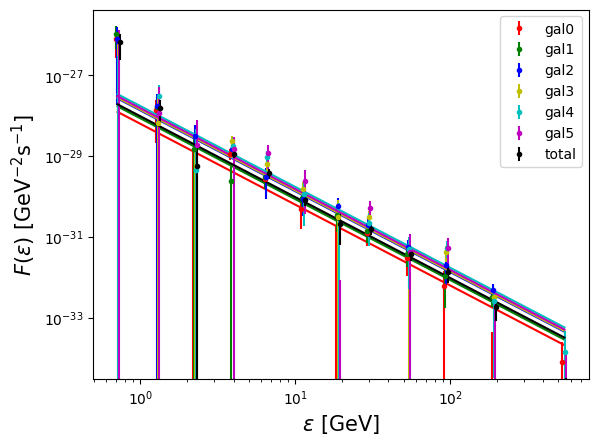

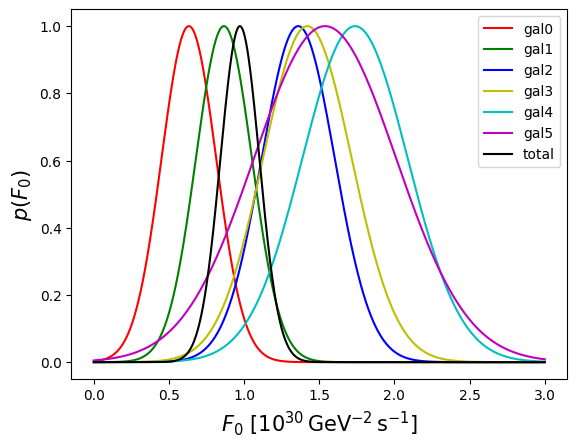

In [10]:
alpha = -2.0
if alpha == -2:
    Eeff = np.log(E_obs[1:]/E_obs[:-1])/(1/E_obs[:-1]-1/E_obs[1:])
else:
    rat_alpha = ((alpha+1)/(alpha+2))
    num = (E_obs[1:]**(alpha+2)-E_obs[:-1]**(alpha+2))
    den = (E_obs[1:]**(alpha+1)-E_obs[:-1]**(alpha+1))
    Eeff = rat_alpha*num/den

E0 = 10.
s = (Eeff/E0)**alpha

res_F0 = {}
plt.figure()
for i, (k, (F, cov_F)) in enumerate(res_F.items()):
    icov = np.linalg.inv(cov_F)
    covF0 = 1/np.dot(s, np.dot(icov, s))
    F0 = covF0*np.dot(s, np.dot(icov, F))
    col = cols[i]
    plt.errorbar(Eeff*(1+0.01*i-0.03), F, yerr=np.sqrt(np.diag(cov_F)), fmt=col+'.', label=k)
    plt.plot(Eeff, F0*s, col+'-')
    err_F0 = np.sqrt(covF0)
    r = F-F0*s
    res_F0[k] = [F0, err_F0]
    chi2 = np.dot(r, np.dot(icov, r))
    print(k, F0, err_F0, F0/err_F0, chi2, 1-chi2f.cdf(chi2, len(F)-1))
plt.loglog()
plt.legend()
plt.xlabel(r'$\epsilon\,\,[{\rm GeV}]$', fontsize=15)
plt.ylabel(r'$F(\epsilon)\,\,[{\rm GeV}^{-2}{\rm s}^{-1}]$', fontsize=15)

plt.figure()
Farr = np.linspace(0, 30, 1024)*1E-31
for i, (k, (F0, sigF0)) in enumerate(res_F0.items()):
    col = cols[i]
    plt.plot(Farr*1E30, np.exp(-0.5*((Farr-F0)/sigF0)**2), col+'-', label=k)
plt.legend()
plt.xlabel(r'$F_0\,\,[10^{30}\,{\rm GeV}^{-2}\,{\rm s}^{-1}]$', fontsize=15)
plt.ylabel(r'$p(F_0)$', fontsize=15)